In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt

"""
Load AirQualityUCI Data
"""

def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

input_file = 'AirQualityUCI_refined.csv'

df = pd.read_csv(input_file,
                 index_col=[0],
                 parse_dates=[0],
                 date_parser=parser)

df.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30592\4122421229.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,C6H6(GT)
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,11.9
2004-03-10 19:00:00,2.0,1292.0,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,9.4
2004-03-10 20:00:00,2.2,1402.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,9.0
2004-03-10 21:00:00,2.2,1376.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,9.2
2004-03-10 22:00:00,1.6,1272.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,6.5


In [2]:
nox = df['PT08.S3(NOx)'].copy()
nox.interpolate(inplace=True)


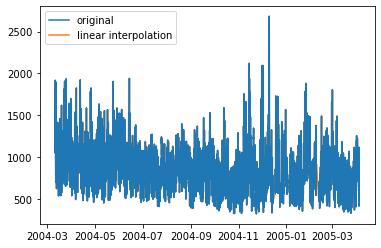

In [3]:
plt.plot(df['PT08.S3(NOx)'], label='original', zorder=2)
plt.plot(nox, label='linear interpolation', zorder=1)
plt.legend(loc='best')

In [4]:
# IQR기반 이상치 탐지

Text(0.5, 0, 'PT08.S3(NOx)')

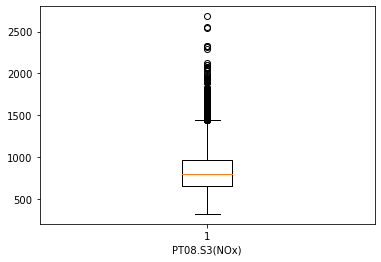

In [5]:
plt.boxplot(nox)
plt.xlabel("PT08.S3(NOx)")

In [6]:
q1 = nox.quantile(0.25)
median = nox.quantile(0.5)
q3 = nox.quantile(0.75)
print(q1 ,median, q3)

654.0 804.0 968.0


In [7]:
iqr = q3-q1
upper_fence = q3 + 1.5*iqr
lower_fence = q1 - 1.5*iqr
print(upper_fence, lower_fence)

1439.0 183.0


In [8]:
outliers = nox.loc[(nox > upper_fence) | (nox < 0)]
outliers

Datetime
2004-03-11 00:00:00    1462.0
2004-03-11 01:00:00    1453.0
2004-03-11 02:00:00    1579.0
2004-03-11 03:00:00    1705.0
2004-03-11 04:00:00    1818.0
                        ...  
2005-03-01 03:00:00    1791.0
2005-03-01 04:00:00    1804.0
2005-03-01 05:00:00    1727.0
2005-03-01 06:00:00    1677.0
2005-03-07 04:00:00    1490.0
Name: PT08.S3(NOx), Length: 239, dtype: float64

In [9]:
mask = nox.index.isin(outliers.index)
mask[:20]

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False])

In [10]:
nox_refined_iqr = nox.copy()
nox_refined_iqr[mask] = np.nan
nox_refined_iqr


Datetime
2004-03-10 18:00:00    1056.0
2004-03-10 19:00:00    1174.0
2004-03-10 20:00:00    1140.0
2004-03-10 21:00:00    1092.0
2004-03-10 22:00:00    1205.0
                        ...  
2005-04-04 10:00:00     539.0
2005-04-04 11:00:00     604.0
2005-04-04 12:00:00     603.0
2005-04-04 13:00:00     702.0
2005-04-04 14:00:00     654.0
Name: PT08.S3(NOx), Length: 9357, dtype: float64

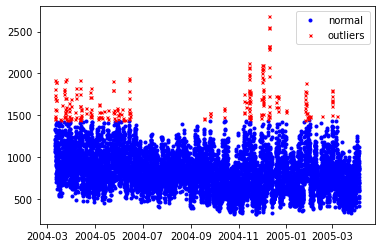

In [11]:
plt.plot(nox[~mask], label='normal', color='blue',
    marker='o', markersize=3, linestyle='None')
plt.plot(outliers, label='outliers', color='red',
    marker='x', markersize=3, linestyle='None')
plt.legend(loc='best')

In [12]:
# Z-score 기반 이상치 탐지

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PT08.S3(NOx)', ylabel='Density'>

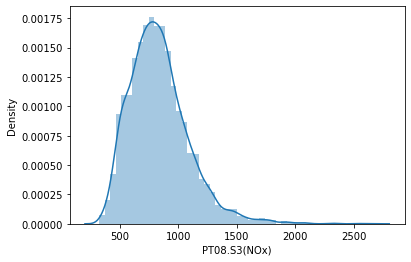

In [13]:
import seaborn as sns
sns.distplot(nox)


In [14]:
mean = np.mean(nox)
std = np.std(nox)
print(mean, std)


832.7588970823982 255.69616900657363


In [15]:
thres = 3

outliers_z = nox.loc[np.abs((nox-mean)/std) > thres]
outliers_z


Datetime
2004-03-11 03:00:00    1705.0
2004-03-11 04:00:00    1818.0
2004-03-11 05:00:00    1918.0
2004-03-11 06:00:00    1738.0
2004-03-12 03:00:00    1680.0
                        ...  
2005-02-28 06:00:00    1665.0
2005-03-01 03:00:00    1791.0
2005-03-01 04:00:00    1804.0
2005-03-01 05:00:00    1727.0
2005-03-01 06:00:00    1677.0
Name: PT08.S3(NOx), Length: 111, dtype: float64

In [16]:
mask_z = nox.isin(outliers_z.index)
mask_z[:20]

Datetime
2004-03-10 18:00:00    False
2004-03-10 19:00:00    False
2004-03-10 20:00:00    False
2004-03-10 21:00:00    False
2004-03-10 22:00:00    False
2004-03-10 23:00:00    False
2004-03-11 00:00:00    False
2004-03-11 01:00:00    False
2004-03-11 02:00:00    False
2004-03-11 03:00:00    False
2004-03-11 04:00:00    False
2004-03-11 05:00:00    False
2004-03-11 06:00:00    False
2004-03-11 07:00:00    False
2004-03-11 08:00:00    False
2004-03-11 09:00:00    False
2004-03-11 10:00:00    False
2004-03-11 11:00:00    False
2004-03-11 12:00:00    False
2004-03-11 13:00:00    False
Name: PT08.S3(NOx), dtype: bool

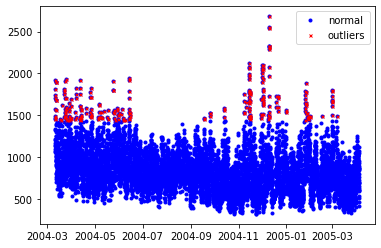

In [17]:
plt.plot(nox[~mask_z], label='normal', color='blue',
    marker='o', markersize=3, linestyle='None')
plt.plot(outliers, label='outliers', color='red',
    marker='x', markersize=3, linestyle='None')
plt.legend(loc='best')